In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D,BatchNormalization
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [3]:
teacher = keras.Sequential(
    [
        Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28, 28, 1)),
        BatchNormalization(axis = 1),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, 
                        kernel_size=(3, 3), 
                        activation='relu'),
        BatchNormalization(axis = 1),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(axis = 1),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(axis = 1),
        Dropout(0.4),
        Dense(10, activation='softmax')        
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=(28, 28, 1)),
        BatchNormalization(axis = 1),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(10, activation='softmax')
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [4]:
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
trained_data=teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


1875/1875 [==============================] - 139s 73ms/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9852
Epoch 2/5
1875/1875 [==============================] - 135s 72ms/step - loss: 0.0410 - sparse_categorical_accuracy: 0.9877
Epoch 3/5
1875/1875 [==============================] - 134s 71ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9878
Epoch 4/5
1875/1875 [==============================] - 136s 73ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9894
Epoch 5/5
313/313 [==============================] - 6s 20ms/step - loss: 0.0206 - sparse_categorical_accuracy: 0.9932


[0.020638858899474144, 0.9932000041007996]

In [12]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
train_student = distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 96s 51ms/step - sparse_categorical_accuracy: 0.9850 - student_loss: 0.0509 - distillation_loss: 1.0494e-05
Epoch 2/3
1875/1875 [==============================] - 96s 51ms/step - sparse_categorical_accuracy: 0.9892 - student_loss: 0.0338 - distillation_loss: 7.5224e-06
Epoch 3/3
313/313 [==============================] - 4s 13ms/step - sparse_categorical_accuracy: 0.9809 - student_loss: 0.0846


[0.98089998960495, 0.00017592313815839589]

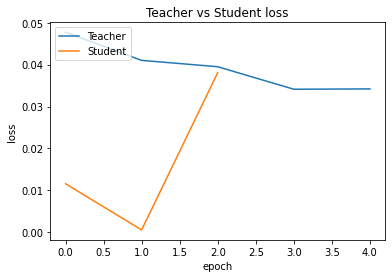

In [14]:
plt.plot(trained_data.history["loss"])
plt.plot(train_student.history["student_loss"])
plt.title("Teacher vs Student loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Teacher", "Student"], loc="upper left")

In [15]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
student_new = student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 67s 35ms/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9850
Epoch 2/3
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0327 - sparse_categorical_accuracy: 0.9901
Epoch 3/3
313/313 [==============================] - 4s 12ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9812


[0.0913790762424469, 0.9811999797821045]

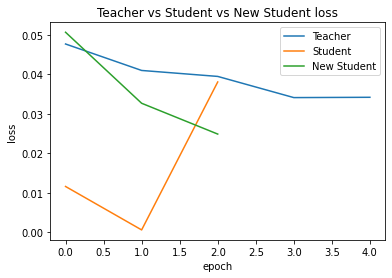

In [18]:
plt.plot(trained_data.history["loss"])
plt.plot(train_student.history["student_loss"])
plt.plot(student_new.history["loss"])
plt.title("Teacher vs Student vs New Student loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Teacher", "Student","New Student"], loc="upper right")